In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.io import loadmat
import pandas as pd
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
data = loadmat(os.path.join('ex4data1.mat'))
print(data.keys())
X, y = data['X'], data['y'].reshape(-1) #flatten the y array
y[y==10]=0
print("The Xs in training set: ")
print(X)
print("The ys in training set: ")
print(y)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
The Xs in training set: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The ys in training set: 
[0 0 0 ... 9 9 9]


In [3]:
#taken from https://github.com/dibgerge/ml-coursera-python-assignments/blob/master/Exercise3/exercise3.ipynb 
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])

        
def sigmoid(z):
    #compute the sigmoid function
    return 1.0 / (1.0 + np.exp(-z))

def sigmoidGradient(z):
    return sigmoid(z)*(1.0-sigmoid(z))


5000 400


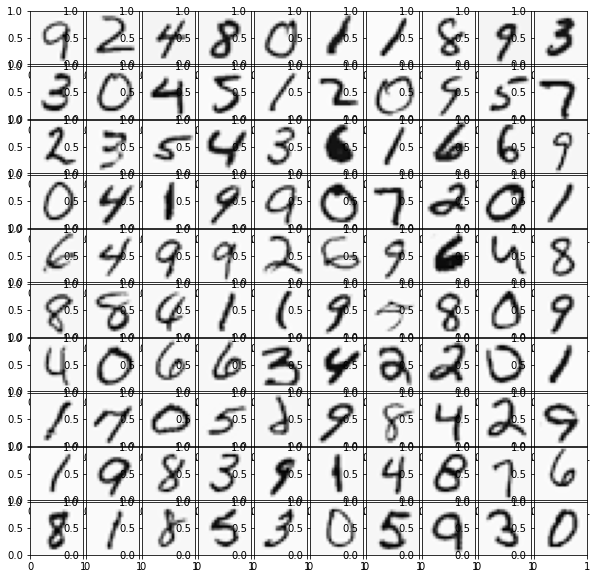

In [4]:
#size of the training set
m,n=X.shape
print(m,n)
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
dis= X[rand_indices, :]
displayData(dis)

In [5]:
#set up parameters
input_layer_size=n
hidden_layer_size=25
num_labels=10
weights = loadmat('ex4weights.mat')
weights.keys()
Theta1, Theta2=weights['Theta1'], weights['Theta2']
Theta2 = np.roll(Theta2, 1, axis=0)
print(Theta1.shape)
print(Theta2.shape)
nn_params = np.concatenate([Theta1.reshape(-1), Theta2.reshape(-1)])

(25, 401)
(10, 26)


Thanks to this notebook https://github.com/dibgerge/ml-coursera-python-assignments/blob/master/Exercise3/exercise3.ipynb helped me to do the exercises in python
    

In [6]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0.0):
    
    "Part 1: Feedforward the neural network and return the cost in the variable J."
    
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # return variables
    j = 0.0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    #sum over the training set
    for i in range(m):
        #add bias to input layer
        a_1 = np.concatenate((np.ones((1)),X[i]),axis=0)         
        z_2 = np.dot(Theta1,a_1)
        #add bias to hidden layer
        a_2 = np.concatenate((np.ones(1), sigmoid(z_2)),axis=0)  
        z_3 = np.dot(Theta2, a_2)
        a_3 = sigmoid(z_3)
        
        output = np.zeros(num_labels)
        output[int(y[i])] = 1
        
        #calculate the deltas
        delta3 = a_3-output
        delta2 = np.dot(Theta2[:,1:].T,delta3)*sigmoid(z_2) #ignore the first column of Theta2
        
        #calculate j by summing over k outputs
        j += np.sum(-output*np.log(a_3) - (1-output)*np.log(1-a_3))
        
        #calculate the gradients
        Theta1_grad = Theta1_grad + np.dot(delta2.reshape(delta2.shape[0],1), a_1.reshape(a_1.shape[0],1).T)
        Theta2_grad = Theta2_grad + np.dot(delta3.reshape(delta3.shape[0],1), a_2.reshape(a_2.shape[0],1).T)
     
    #implement regularization
    j=j/m + (lambda_/(2*m)) * (np.sum(Theta1[:,1:]**2)+np.sum(Theta2[:,1:]**2))
    
    
    # Unroll gradients
    # grad = np.concatenate([Theta1_grad.ravel(order=order), Theta2_grad.ravel(order=order)]
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    
    #calculate the partial derivatives
    D_1 = np.hstack( ((1/m)*Theta1_grad[:,0:1], (1/m)*(Theta1_grad[:,1:] + lambda_*Theta1[:,1:])))
    D_2 = np.hstack(((1/m)*Theta2_grad[:,0:1], (1/m)*(Theta2_grad[:,1:] + lambda_*Theta2[:,1:])))
    #print(D_1)
    #print(grad)
    g_d=np.concatenate([D_1.ravel(),D_2.ravel()])
    return j, g_d
    

In [7]:
#check J is right without regularization
lambda_ = 0
Jc, _= nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % Jc)
print('The cost should be about                   : 0.287629.')

Cost at parameters (loaded from ex4weights): 0.287629 
The cost should be about                   : 0.287629.


In [8]:
#check j with regularization
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')

Cost at parameters (loaded from ex4weights): 0.383770
This value should be about                 : 0.383770.


In [9]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    W = np.zeros((L_out, 1 + L_in))
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return W

#function to predict
def predict(Theta1 ,Theta2 ,X):  
    if X.ndim == 1:
        X = X[None]
        
    m = X.shape[0]
    p = np.zeros(m)
    for i in range(m):
        #add bias to input layer
        a_1=np.concatenate((np.ones(1),X[i]), axis=0)         
        z_2 = np.dot(Theta1,a_1)
        #add bias to hidden layer
        a_2=np.concatenate((np.ones(1),sigmoid(z_2)),axis=0) 
        z_3 = np.dot(Theta2, a_2)
        a_3 = sigmoid(z_3)  
        p[i] = np.argmax(a_3)
      
    return p 

In [13]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


In [23]:
options= {'maxiter': 1500}
lambda_ = 2.5

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params_ = res.x
        
# get the final Theta1 and Theta2 back from nn_params_
Final_Theta1 = np.reshape(nn_params_[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, (input_layer_size + 1)))

Final_Theta2 = np.reshape(nn_params_[(hidden_layer_size * (input_layer_size + 1)):], (num_labels, (hidden_layer_size + 1)))

In [24]:
pred = predict(Final_Theta1, Final_Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 67.860000
